In [47]:
import numpy as np
from scipy.fftpack import fft
import random

In [48]:
# Choose the signal frequency (0.2Hz) and the number of cycles to sample over (2) and the number of samples (50)

f_s = 0.2345
N_cycles = 1.8
N_samples = 50

# Calculate the timespan
period = 1/f_s
T =  N_cycles*period

# Set the number of terms in the Fourier series (initially, equal to the number of samples, which is bad!)

N_terms = int(N_samples/2)

random.seed(1)

In [49]:
# Calculate the spacing (in time) between data points
dt = T/N_samples

# Set up arrays to hold the time (x-axis), amplitude (y-axis), and frequencies (Fourier transform)
t = np.zeros(N_samples)
y = np.zeros(N_samples)
f = np.zeros(N_terms)

yhigh = np.zeros(1000)
ylow = np.zeros(1000)
time = np.zeros(1000)

ytReal = np.zeros(N_terms)
ytImag = np.zeros(N_terms)

yfftReal = np.zeros(N_terms)
yfftImag = np.zeros(N_terms)

power = np.zeros(N_terms)
powerfft = np.zeros(N_terms)

## Theory

The function that we will choose is:

$y(t) = sin(2 \pi f_s t)$

The Fourier approximation is given by:

$y(t) \approx \frac{a_0}{2} + \sum_{n=1}^{\infty} \left ( a_n cos(\frac{2 \pi n t}{T}) + b_n sin(\frac{2 \pi n t}{T}) \right )$

where $T$ is the time-span.

For the chosen function, we expect:

$a_0 = 0$

$a_n = 0,~for~all~n$

Since we have a single sine wave with with frequency, $f_s$, we would expect one of the $b_n$ values to be non-zero, and the rest zero.  The value of n for the single non-zero $b_n$ value can be calculated from:

$2 \pi f_s = \frac{2 \pi n}{T}$

$n = T\cdot f_s = (0.2)(10.0) = 2$

Thus, we expect:

$b_2 = 1, and~all~other~b_n=0$

In [50]:
# Create the data set.  Add a little bit of random noise into the signal.

for i in range(N_samples):
    t[i]=i*dt
    y[i]=(1.0+0.00000002*random.uniform(0,1))*np.sin(2.0*np.pi*t[i]*f_s)
    
for i in range(N_terms):
    f[i] = i/(N_terms*dt)
    
    
print (y,f,t)

[ 0.          0.22427076  0.43711577  0.62769136  0.78628844  0.90482706
  0.97726814  0.99992106  0.97163173  0.89384142  0.77051326  0.6079303
  0.41437559  0.19970998 -0.0251301  -0.24868989 -0.45957986 -0.64705597
 -0.801567   -0.91524117 -0.98228725 -0.99928948 -0.96538166 -0.88229123
 -0.75425138 -0.58778526 -0.39137367 -0.17502306  0.05024432  0.27295194
  0.48175368  0.66601187  0.81633925  0.92507722  0.98668595  0.99802673
  0.95852181  0.87018376  0.73751313  0.56726895  0.36812456  0.15022559
 -0.07532681 -0.29704158 -0.50362321 -0.68454712 -0.83059591 -0.93432895
 -0.99046144 -0.99613362] [0.         0.26055556 0.52111111 0.78166667 1.04222222 1.30277778
 1.56333333 1.82388889 2.08444444 2.345      2.60555556 2.86611111
 3.12666667 3.38722222 3.64777778 3.90833333 4.16888889 4.42944444
 4.69       4.95055556 5.21111111 5.47166667 5.73222222 5.99277778
 6.25333333] [0.         0.15351812 0.30703625 0.46055437 0.61407249 0.76759062
 0.92110874 1.07462687 1.22814499 1.3816631

# Calculating the coefficients

We will determine the coefficients by numerical integration, according to:

$a_0 = \frac{1}{T} \int_0^T f(t) dt$

$a_n = \frac{1}{T} \int_0^T f(t) cos(\frac{2 \pi n}{T} t) dt$

$b_n = \frac{1}{T} \int_0^T f(t) sin(\frac{2 \pi n}{T} t) dt$

In [51]:
from timeit import default_timer as timer

start = timer()

# Define a useful constant, because I am sick of typing it so many times!

twopiT=2.0*np.pi/T

# rather than just making things exactly zero, make them a small number, so that logarithmic plots do not fail.
epsilon = 0.001

for n in range(N_terms):
    ytReal[n]=epsilon
    ytImag[n]=epsilon
    for i in range(N_samples):
        ytReal[n] = ytReal[n] + 2.0/T*y[i]*np.cos(twopiT*n*i*dt)*dt
        ytImag[n] = ytImag[n] + 2.0/T*y[i]*np.sin(twopiT*n*i*dt)*dt  
    power[n]=(ytReal[n]**2+ytImag[n]**2)
    
end = timer()
btime = end-start
print ("Brash: ",btime)
ymaxr = max(ytReal)
ymaxi = max(ytImag)
ymax = 1.2*max(ymaxr,ymaxi)

Brash:  0.009963891468942165


In [52]:
integral = 0.0
N_real = int(N_terms)

for n in range(N_real):
    integral = integral + power[n]
print("Average Power = %.2f Watts." % (integral/2.0))

#Nyquist frequency is 1/2 the sampling rate frequency
f_nyquist = 0.5*(1.0/dt)
print("Nyquist frequency = %.2f Hz." % f_nyquist)

for i in range(1000):
    time[i] = i*T/1000.0
    ylow[i] = np.sin(2.0*np.pi*time[i]*f_s)
    yhigh[i] = -np.sin(2.0*np.pi*time[i]*(2.0*f_nyquist-f_s))


Average Power = 0.51 Watts.
Nyquist frequency = 3.26 Hz.


In [55]:
start = timer()
N_fft = len(y)
yfft = fft(y)
yfftReal =2.0/N_fft*yfft.real
yfftImag = 2.0/N_fft*yfft.imag
powerfft = 4.0/N_fft**2*abs(yfft)**2
end = timer()
print ("Python: ",(end-start))
print("Ratio = ",btime/(end-start))

for i in range(N_terms):
    print (ytReal[i],yfftReal[i],ytImag[i],yfftImag[i],power[i],powerfft[i])
    

Python:  0.0005120653659105301
Ratio =  19.458241334531287
0.1416923201847895 0.1406923201847894 0.001 -0.0 0.020077713599348908 0.019794328958979295
0.19624218614247246 0.19524218614247243 -0.13454713595557577 0.13554713595557602 0.056613927415825 0.056492537315451265
-0.5014284110987549 -0.5024284110987556 0.796860073853144 -0.7958600738531435 0.8864164287582601 0.8858275654327511
-0.04923739401548263 -0.05023739401548298 0.1574711660150318 -0.15647116601503197 0.027221489095569595 0.027007021551570587
-0.011533945473791399 -0.012533945473791615 0.09429547589217745 -0.09329547589217754 0.009024668671924611 0.008861145611087862
0.001295084085178172 0.0002950840851777947 0.0685508924996866 -0.06755089249968649 0.00470090210529127 0.004563210152121526
0.007399498404878711 0.006399498404878423 0.05402554593964169 -0.05302554593964195 0.0029735121907201374 0.0028526621020311207
0.010827066010521504 0.00982706601052158 0.04447643805434495 -0.04347643805434506 0.002095378900398174 0.0019867

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


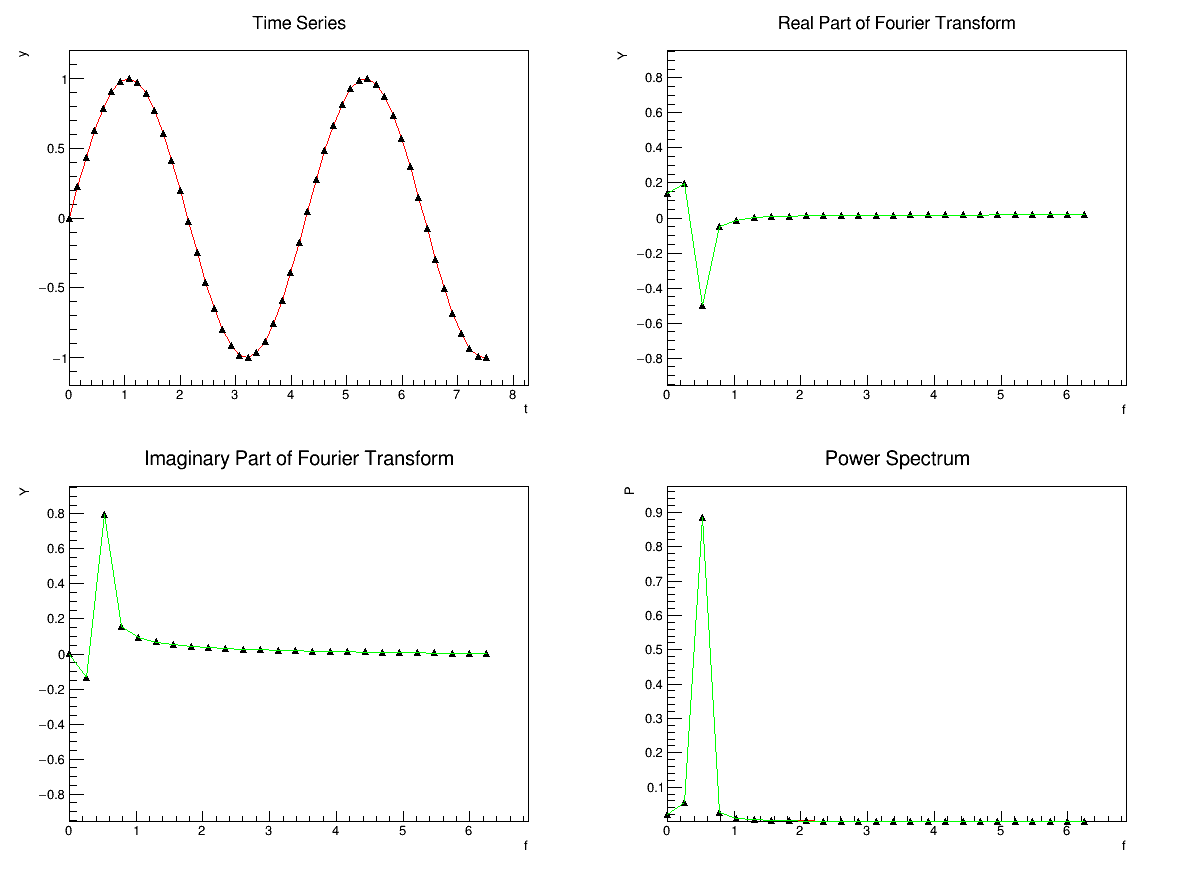

In [56]:
from ROOT import TCanvas, TFile
from ROOT import TGraph, TF1
from ROOT import gStyle, gPad

Ns = N_samples
Nt = N_terms

gStyle.SetOptFit(1)

c1 = TCanvas( 'c1', 'Fourier Transform', 200, 10, 1200, 900 )
c1.SetGridx()
c1.SetGridy()
c1.GetFrame().SetFillColor( 21 )
c1.GetFrame().SetBorderMode(-1 )
c1.GetFrame().SetBorderSize( 5 )
c1.Divide(2,2)

c1.cd(1)
gr = TGraph(Ns,t,y)
gr.SetMarkerStyle(22)
gr.SetLineColor(2)
gr.SetTitle("Time Series")
gr.GetXaxis().SetTitle("t")
gr.GetYaxis().SetTitle("y")
gr.Draw("APL")

c1.cd(2)
grr = TGraph(Nt,f,ytReal)
grr.SetMarkerStyle(22)
grr.SetLineColor(2)
grr.SetTitle("Real Part of Fourier Transform")
grr.GetXaxis().SetTitle("f")
grr.GetYaxis().SetTitle("Y")
grr.GetHistogram().SetMaximum(ymax)
grr.GetHistogram().SetMinimum(-1.0*ymax)

grrfft = TGraph(Nt,f,yfftReal)
grrfft.SetMarkerStyle(23)
grrfft.SetLineColor(3)
grrfft.SetTitle("Real Part of Fourier Transform")
grrfft.GetXaxis().SetTitle("f")
grrfft.GetYaxis().SetTitle("Y")
grrfft.GetHistogram().SetMaximum(ymax)
grrfft.GetHistogram().SetMaximum(-1.0*ymax)

grr.Draw("AP")
grrfft.Draw("L")

c1.cd(3)
gri = TGraph(Nt,f,ytImag)
grifft = TGraph(Nt,f,-yfftImag)
gri.SetMarkerStyle(22)
grifft.SetMarkerStyle(23)
gri.SetLineColor(2)
grifft.SetLineColor(3)
gri.SetTitle("Imaginary Part of Fourier Transform")
gri.GetXaxis().SetTitle("f")
gri.GetYaxis().SetTitle("Y")
gri.GetHistogram().SetMaximum(ymax)
gri.GetHistogram().SetMinimum(-1.0*ymax)
gri.Draw("AP")
grifft.Draw("L")

c1.cd(4)
#gPad.SetLogy()
grp = TGraph(Nt,f,power)
grpfft = TGraph(Nt,f,powerfft)
grp.SetMarkerStyle(22)
grpfft.SetMarkerStyle(23)
grp.SetLineColor(2)
grpfft.SetLineColor(3)
grp.SetTitle("Power Spectrum")
grp.GetXaxis().SetTitle("f")
grp.GetYaxis().SetTitle("P")
gri.GetHistogram().SetMaximum(ymax)
grp.Draw("APL")
grpfft.Draw("L")

c1.Draw()

In [57]:
c2 = TCanvas( 'c1', 'Fourier Transform', 200, 10, 1200, 900 )
c2.SetGridx()
c2.SetGridy()
c2.GetFrame().SetFillColor( 21 )
c2.GetFrame().SetBorderMode(-1 )
c2.GetFrame().SetBorderSize( 5 )



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


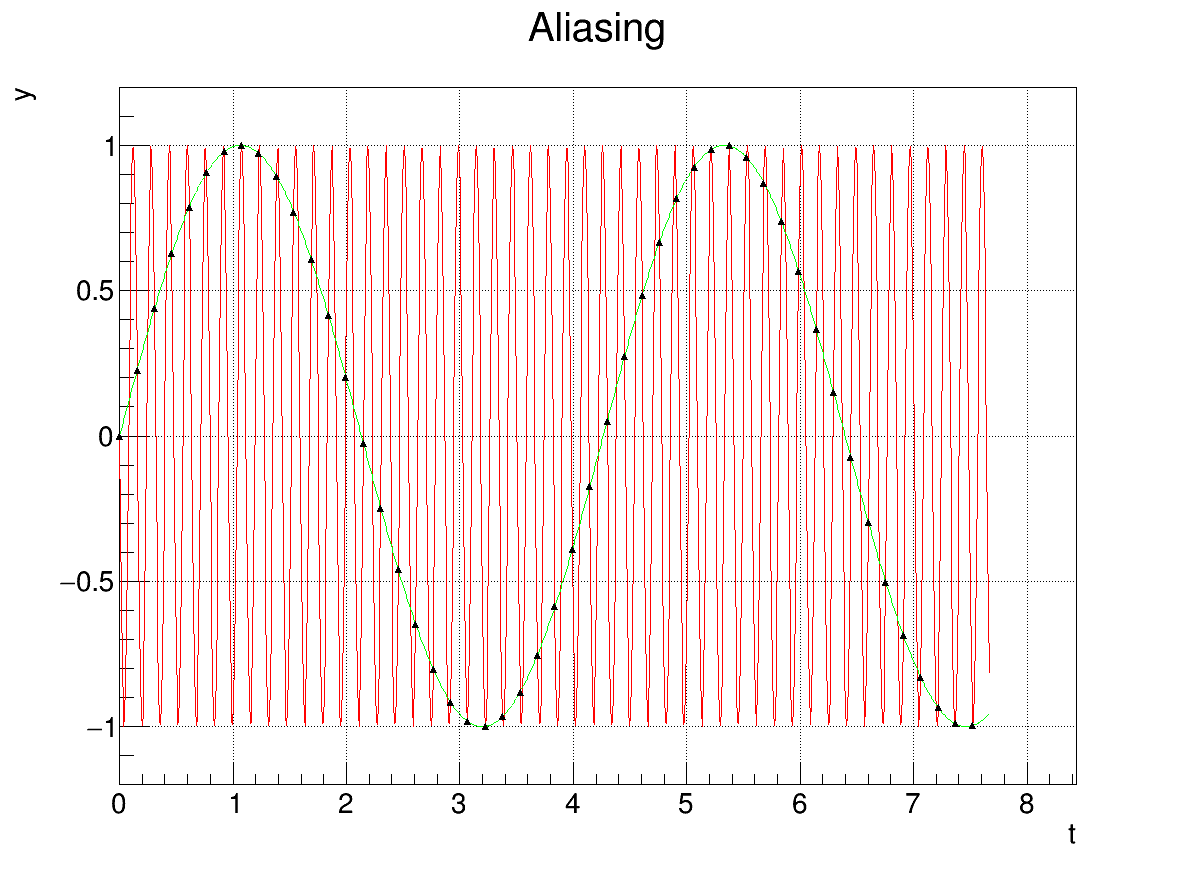

In [58]:
c2.cd()
grhigh = TGraph(1000,time,yhigh)
grlow = TGraph(1000,time,ylow)
grhigh.SetMarkerStyle(22)
grhigh.SetLineColor(2)
grhigh.SetTitle("Aliasing")
grhigh.GetXaxis().SetTitle("t")
grhigh.GetYaxis().SetTitle("y")
grlow.SetMarkerStyle(22)
grlow.SetLineColor(3)
grhigh.Draw("AL")
grlow.Draw("L")
gr.Draw("P")
c2.Draw()